In [1]:
# imports de bibliotecas
import numpy as np
import mne
from scipy.signal import welch
import matplotlib.pyplot as plt

In [2]:
# definição do info (MNE)

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [3]:
# carregamento e organização dos dados de: Guilherme Kipper

tf = [
  '../dataset/OpenBCI-RAW-2023-11-28_15-44-34.txt', # REMOVE:(15-16) (60-67) (111-114)
  '../dataset/OpenBCI-RAW-2023-11-28_15-50-35.txt', # REMOVE:(14-16) (96-99)
  '../dataset/OpenBCI-RAW-2023-11-28_15-53-44.txt'  # REMOVE:(00-37)
  ]


tf_ob = [np.loadtxt(txt, delimiter=',', skiprows=5, usecols=range(1, 9)) for txt in tf]




data_tf = np.concatenate((
  tf_ob[0][17*sfreq:59*sfreq,:], tf_ob[0][68*sfreq:110*sfreq,:], tf_ob[0][115*sfreq:,:], # 17-59, 68-110, 115-248(final) = 217
  tf_ob[1][17*sfreq:95*sfreq,:], tf_ob[1][100*sfreq:,:], # 17-95, 100-143(final) = 121
  tf_ob[2][38*sfreq:,:] #38-318(final) = 280
))


x_tf = mne.io.RawArray(data_tf.T, info)
x_tf.set_eeg_reference(ref_channels='average') # CAR

X = {
    'tf':  x_tf,
}

Creating RawArray with float64 data, n_channels=8, n_times=154980
    Range : 0 ... 154979 =      0.000 ...   619.916 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [4]:
# filtragem de todos os dados

for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband e

In [5]:
# salvando os dados filtrados em arquivos .fif (MNE)

for key in X:
    X[key].save('../dataset/filtered/' + key + '.fif', overwrite=True)

Overwriting existing file.
Writing /home/glob/faculdade/2024/reconhecimento-padroes/LUIS/teste_completo/../dataset/filtered/tf.fif
Closing /home/glob/faculdade/2024/reconhecimento-padroes/LUIS/teste_completo/../dataset/filtered/tf.fif
[done]


/tmp/ipykernel_16836/331378711.py:4: RuntimeWarning: This filename (/home/glob/faculdade/2024/reconhecimento-padroes/LUIS/teste_completo/../dataset/filtered/tf.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  X[key].save('../dataset/filtered/' + key + '.fif', overwrite=True)


In [6]:

# abrindo os dados filtrados salvos em arquivos .fif (MNE)


sr = 250          # taxa de amostragem
jump = 5          # 5s de buffer
size = sr * jump  # quantidade de pontos avalidados


# Definir os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

total_pc = {}
data_names = ('tf')

#for calculate the intervals
parts_total= [[0,0,0,0]]
interval=10

nperseg = 128  # Número de pontos por segmento
noverlap = nperseg // 2  # Quantidade de sobreposição entre segmentos

for k, data in enumerate(X.values()):
    results = [0, 0, 0, 0]
    for i in range(0, len(data)-1, sr):
        cut = data.get_data(start=i, stop=i+size) 
        freqs, psd = welch(cut, fs=sr, nperseg=nperseg, noverlap=noverlap)
        X = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        # Calcular a potência em cada banda de frequência
        bands = [np.sum(X[theta_idxs]), np.sum(X[alpha_idxs]), np.sum(X[beta_idxs]), np.sum(X[gamma_idxs])]
        results[np.argmax(bands)] += 1


        # Calcula a onda mais alta em um intervalo de 10s
        current_interval = (i//250) // interval
        if len(parts_total) <= current_interval:
            parts_total.append([0,0,0,0])
        parts_total[current_interval][np.argmax(bands)] += 1
        
    total = sum(results)
    percentages = [round((count/total) * 100, 2) for count in results]
    print(data.__str__())
    print(percentages)
    total_pc[data_names[k]] = percentages

print(total_pc)
for parts in parts_total:
    print(parts)

<RawArray | 8 x 154980 (619.9 s), ~9.5 MB, data loaded>
[40.97, 0.0, 4.19, 54.84]
{'t': [40.97, 0.0, 4.19, 54.84]}
[0, 0, 0, 10]
[6, 0, 0, 4]
[6, 0, 0, 4]
[10, 0, 0, 0]
[10, 0, 0, 0]
[10, 0, 0, 0]
[10, 0, 0, 0]
[10, 0, 0, 0]
[10, 0, 0, 0]
[10, 0, 0, 0]
[10, 0, 0, 0]
[10, 0, 0, 0]
[8, 0, 2, 0]
[10, 0, 0, 0]
[10, 0, 0, 0]
[7, 0, 3, 0]
[8, 0, 0, 2]
[10, 0, 0, 0]
[10, 0, 0, 0]
[6, 0, 0, 4]
[10, 0, 0, 0]
[7, 0, 0, 3]
[0, 0, 0, 10]
[0, 0, 0, 10]
[0, 0, 0, 10]
[3, 0, 1, 6]
[2, 0, 1, 7]
[0, 0, 0, 10]
[0, 0, 0, 10]
[4, 0, 0, 6]
[0, 0, 0, 10]
[0, 0, 0, 10]
[0, 0, 0, 10]
[5, 0, 0, 5]
[6, 0, 0, 4]
[0, 0, 0, 10]
[0, 0, 1, 9]
[0, 0, 4, 6]
[4, 0, 0, 6]
[9, 0, 0, 1]
[2, 0, 8, 0]
[6, 0, 2, 2]
[0, 0, 0, 10]
[0, 0, 0, 10]
[1, 0, 0, 9]
[5, 0, 3, 2]
[7, 0, 1, 2]
[2, 0, 0, 8]
[0, 0, 0, 10]
[0, 0, 0, 10]
[5, 0, 0, 5]
[0, 0, 0, 10]
[0, 0, 0, 10]
[0, 0, 0, 10]
[0, 0, 0, 10]
[0, 0, 0, 10]
[0, 0, 0, 10]
[0, 0, 0, 10]
[0, 0, 0, 10]
[0, 0, 0, 10]
[3, 0, 0, 7]
[2, 0, 0, 8]


In [7]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [6., 4.]

def plot_bar(x):
    colors = ('orange', 'green', 'blue', 'purple')
    bars = plt.bar(('theta', 'alpha', 'beta', 'gamma'), x, color=colors)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    plt.title('Porcentagem da potência em cada banda de frequência')
    plt.xlabel('Banda de Frequência')
    plt.ylabel('Porcentagem durante a atividade')

    # Exibir o gráfico
    plt.show()

TESTE FINAL


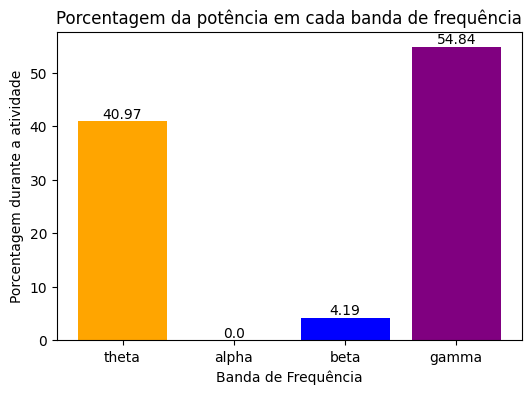

In [8]:
print('TESTE FINAL')
plot_bar(total_pc['t'])
# print('Glucagon Ativa - Teste')
# plot_bar(total_pc['ga_test'])